## Import packages

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

## Defining Transforms

In [18]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

## Prepare train and test sets, loaders

In [19]:
root = './CATS_DOGS'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['CAT', 'DOG']
Training images available: 18743
Testing images available:  6251


## create function to count the trainable parameters

In [20]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

## Download pre-trained model : AlexNet

In [21]:
AlexNetmodel = models.alexnet(pretrained=True)
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

## Freeze the pre-trained weights and biases.

In [ ]:
for param in AlexNetmodel.parameters():
    param.requires_grad = False

## Modify the classifier : have two output classifications (Cat and Dog)

In [23]:
torch.manual_seed(42)
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(1024, 2),
                                 nn.LogSoftmax(dim=1))
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4)
    (3): Linear(in_featur

In [24]:
# These are the TRAINABLE parameters:
count_parameters(AlexNetmodel)

 9437184
    1024
    2048
       2
________
 9440258


## Define Loss funciton and Optimiser

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)

## Train the model

Remember, we're only training the fully connected layers. The convolutional layers have fixed weights and biases. For this reason, we only need to run one epoch.

In [26]:
import time
start_time = time.time()

epochs = 1

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        b+=1
        
        # Apply the model
        y_pred = AlexNetmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/{len(train_data)}]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            

            # Apply the model
            y_val = AlexNetmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/18743]  loss: 0.00360825  accuracy:  89.000%
epoch:  0  batch:  400 [  4000/18743]  loss: 0.08023269  accuracy:  91.475%
epoch:  0  batch:  600 [  6000/18743]  loss: 0.16901389  accuracy:  92.283%
epoch:  0  batch:  800 [  8000/18743]  loss: 0.63549268  accuracy:  92.575%
epoch:  0  batch: 1000 [ 10000/18743]  loss: 0.02381007  accuracy:  92.930%
epoch:  0  batch: 1200 [ 12000/18743]  loss: 0.29725772  accuracy:  93.075%
epoch:  0  batch: 1400 [ 14000/18743]  loss: 0.08902000  accuracy:  93.150%
epoch:  0  batch: 1600 [ 16000/18743]  loss: 0.24756634  accuracy:  93.269%
epoch:  0  batch: 1800 [ 18000/18743]  loss: 0.44485587  accuracy:  93.444%

Duration: 1274 seconds


In [27]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/6251:.3f}%')

[tensor(5933)]
Test accuracy: 94.913%


we see a massive improvement from 78% -> 94% using a pre-trained AlexNet model

## Run a new image through the model

We can also pass a single image through the model to obtain a prediction.
Pick a number from 0 to 6250, assign it to "x", and we'll use that value to select an image from the Cats and Dogs test set.

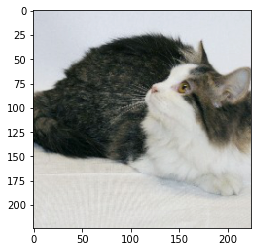

In [30]:
# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

x = 2019
im = inv_normalize(test_data[x][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [31]:
test_data[x][0].shape

torch.Size([3, 224, 224])

In [33]:
# AlexNet Model Prediction:

AlexNetmodel.eval()
with torch.no_grad():
    new_pred = AlexNetmodel(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')

Predicted value: 0 CAT
